Cosmo MCMC is landing on biased HOD + Cosmology. I'm gonna first look at the code to make preds, and compare to the emulator. 

In [30]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path
import h5py
from ast import literal_eval

In [31]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [32]:
chain_fname = '/home/users/swmclau2/scratch/PearceMCMC/b0r1_xi_gg.hdf5'

In [33]:
f = h5py.File(chain_fname, 'r')

In [34]:
emu_type_dict = {'OriginalRecipe':OriginalRecipe,
                     'ExtraCrispy': ExtraCrispy,
                     'SpicyBuffalo': SpicyBuffalo}

fixed_params = f.attrs['fixed_params']
fixed_params = {} if fixed_params is None else literal_eval(fixed_params)
#metric = f.attrs['metric'] if 'metric' in f.attrs else {}
emu_hps = f.attrs['emu_hps']
emu_hps = {} if emu_hps is None else literal_eval(emu_hps)

seed = f.attrs['seed']
seed = int(time()) if seed is None else seed

training_file = f.attrs['training_file']
emu_type = f.attrs['emu_type']

if type(training_file) is str:
    training_file = [training_file]

if type(emu_type) is str:
    emu_type = [emu_type]
    
    

emus = []

np.random.seed(seed)
for et, tf in zip(emu_type, training_file): # TODO iterate over the others?
    emu = emu_type_dict[et](tf,
                             fixed_params = fixed_params,
                             **emu_hps)
    emus.append(emu)
    # TODO write hps to the file too

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:294: UserWarning: WARNING: NaN detected. Skipped 21 points in training data.
  warnings.warn('WARNING: NaN detected. Skipped %d points in training data.' % (num_skipped))


In [35]:
params = {}
sim_params = literal_eval(f.attrs['sim'])
params.update(sim_params['hod_params'])
params.update(sim_params['cosmo_params'])
del params['logMmin']

In [36]:
r_bins = np.logspace(-1.1, 1.6, 19)
rpoints = (r_bins[1:]+r_bins[:-1])/2.0

In [37]:
sim_params = literal_eval(f.attrs['sim'])
cosmo_param_dict = sim_params['cosmo_params']

In [38]:
em_params = params
y_emu = 10**emu.emulate_wrt_r(em_params)[0]

In [39]:
em_params

{'H0': 63.2317,
 'Neff': 2.95,
 'alpha': 1.083,
 'ln10As': 3.03895,
 'logM0': 14.0,
 'logM1': 13.7,
 'ns': 0.9805149999999999,
 'ombh2': 0.023262900000000003,
 'omch2': 0.10783,
 'sigma_logM': 0.2,
 'w0': -0.726513}

In [40]:
boxno, realization = sim_params['sim_hps']['boxno'], sim_params['sim_hps']['realization']

In [41]:
y_calc_jk = f['data']
#y_calc_mean = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xi_gm_true_mean_%d%d.npy'%(boxno, realization))
y_cov_jk = f['cov']

In [42]:
emu_cov = np.loadtxt(path.join("/home/users/swmclau2/Git/pearce/bin/mcmc/config/", literal_eval(f.attrs['cov'])['emu_cov_fname']))

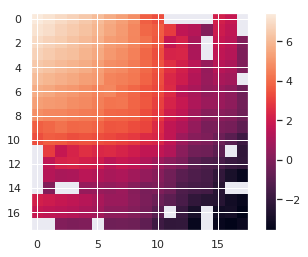

In [43]:
im = plt.imshow(np.log10(emu_cov) )
plt.colorbar(im)
plt.show()

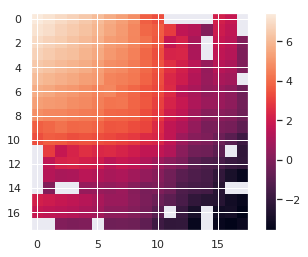

In [44]:
im = plt.imshow(np.log10(y_cov_jk) )
plt.colorbar(im)
plt.show()

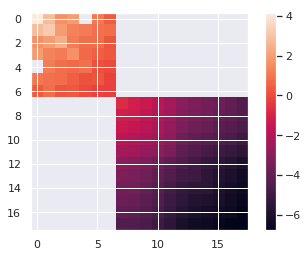

In [45]:
im = plt.imshow(np.log10(y_cov_jk-emu_cov) )
plt.colorbar(im)
plt.show()

In [46]:
print np.diag(emu_cov)
print np.diag(y_cov_jk-emu_cov)

[  2.75173954e+07   1.04571179e+07   3.51136589e+06   1.47689206e+06
   4.55956785e+05   1.52290373e+05   5.25140955e+04   1.84898096e+04
   6.27572328e+03   1.43259746e+03   2.09756307e+02   1.86231196e+01
   7.93269467e-01   4.89433815e-02   2.51625464e-02   3.59556538e-03
   1.10905185e-03   5.66538040e-04]
[  1.43189410e+04   1.70788999e+03   2.70516413e+02   4.67784599e+01
   7.60534132e+00   1.98572306e+00   6.92053099e-01   1.97850799e-01
   6.83846159e-02   1.77981660e-02   3.84910460e-03   3.95499203e-04
   3.59275858e-05   9.96540384e-06   3.00490144e-06   1.04545324e-06
   3.94387358e-07   1.66310961e-07]


In [47]:
#y_cov = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xi_gg_cov_true.npy')
#y_err = np.sqrt(np.diag(y_cov)) + np.sqrt(np.diag(emu.ycov))
#y_err_jk = np.sqrt(np.diag(y_cov_jk)) + np.sqrt(np.diag(scov))
#cov = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xi_gg_cov_true_all.npy')
y_err = np.sqrt(np.diag(y_cov_jk))

In [48]:
n_walkers, n_burn = f.attrs['nwalkers'], 10000#f.attrs['nburn']
chain = f['chain'].value[n_walkers*n_burn:]
param_names = f.attrs['param_names']

In [49]:
MAP = chain.mean(axis = 0)
print MAP

[  2.27615461e-02   1.19417310e-01  -9.86642003e-01   9.85749483e-01
   3.02218461e+00   6.66559982e+01   3.47077513e+00   1.40836334e+01
   1.62733495e-01   1.33915892e+01   1.00230443e+00]


In [50]:
em_params.update(dict(zip(param_names, MAP)))
MAP_xi = 10**emu.emulate_wrt_r(em_params)[0]

In [51]:
em_params

{'H0': 66.655998,
 'Neff': 3.4707751,
 'alpha': 1.0023044,
 'ln10As': 3.0221846,
 'logM0': 14.083633,
 'logM1': 13.391589,
 'ns': 0.98574948,
 'ombh2': 0.022761546,
 'omch2': 0.11941731,
 'sigma_logM': 0.1627335,
 'w0': -0.986642}

In [52]:
varied_param_name = 'ln10As'
bounds = emu.get_param_bounds(varied_param_name)
Nvp = 100
vp_vals = np.linspace(bounds[0], bounds[1], Nvp)

varied_param_xis = []
for val in vp_vals:
    em_params[varied_param_name] = val
    varied_param_xis.append(10**emu.emulate_wrt_r(em_params))

In [53]:
chain_vals = []
rand_idxs = np.random.choice(chain.shape[0], size = 2000, replace = False)
rand_chain = chain[rand_idxs]

for row in rand_chain:
    cosmo_params = dict(zip(param_names, row))
    #cosmo_params['Neff'] = cosmo_param_dict['Neff']
    #cosmo_params['ln10As'] = cosmo_param_dict['ln10As']
    em_params.update(cosmo_params)

    chain_vals.append(10**emu.emulate_wrt_r(em_params))

In [54]:
vp_palette = sns.cubehelix_palette(Nvp)

In [55]:
MAP_xi

array([  4.18567182e+04,   2.77293101e+04,   1.75765612e+04,
         1.19339995e+04,   7.04583682e+03,   4.35229210e+03,
         2.38409482e+03,   1.35927988e+03,   6.45995233e+02,
         2.98182066e+02,   1.01201415e+02,   2.50661228e+01,
         7.85417099e+00,   4.32929249e+00,   2.36887940e+00,
         1.32302046e+00,   6.63303075e-01,   3.49230837e-01])

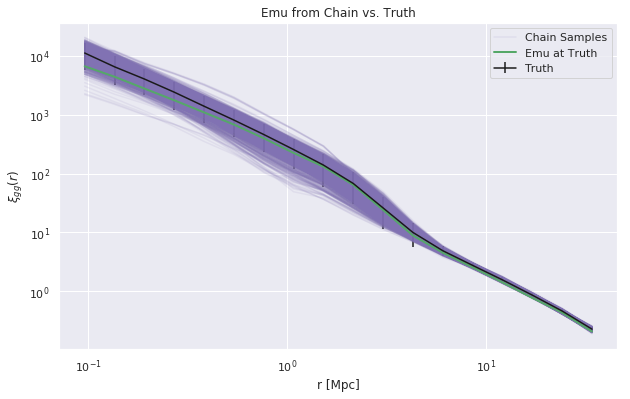

In [56]:
fig = plt.figure(figsize = (10,6))

for idx, val in enumerate(chain_vals):
    if idx == 0:
        plt.plot(rpoints, val[0], c= 'm', alpha = 0.1 , label = 'Chain Samples')
    else:
        plt.plot(rpoints, val[0], c= 'm', alpha = 0.1 )
    
#for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
#    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.8)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')
plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Emu from Chain vs. Truth')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gg}(r)$')
plt.legend(loc = 'best')
plt.show()

In [42]:
y_err

array([  5.24706721e+03,   3.23401079e+03,   1.87393607e+03,
         1.21529373e+03,   6.75251353e+02,   3.90246536e+02,
         2.29161052e+02,   1.35977967e+02,   7.92198944e+01,
         3.78499044e+01,   1.44830990e+01,   4.31549708e+00,
         8.90676930e-01,   2.21254033e-01,   1.58636538e-01,
         5.99717503e-02,   3.33083509e-02,   2.38055530e-02])

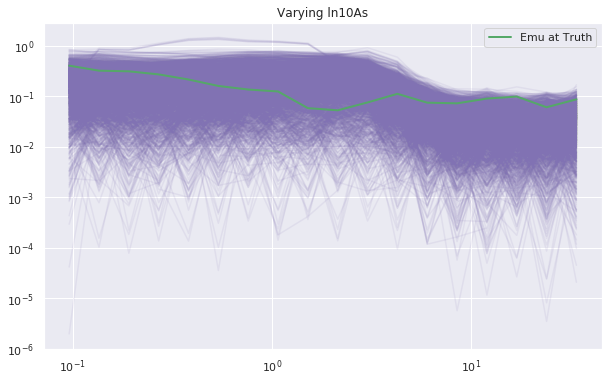

In [28]:
fig = plt.figure(figsize = (10,6))

for val in chain_vals:
    plt.plot(rpoints, np.abs(val[0]-y_calc_jk)/y_calc_jk, c= 'm', alpha = 0.1 )
    
#for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
#    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.8)
    

#plt.plot(rpoints, np.abs(MAP_xi-y_calc_jk)/y_calc_jk, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk.value-y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')
plt.plot(rpoints, np.abs(y_emu-y_calc_jk)/y_calc_jk, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Varying %s'%varied_param_name)
plt.legend(loc = 'best')
plt.show()

In [ ]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.05)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Varying %s'%varied_param_name)
plt.legend(loc = 'best')
plt.show()

In [ ]:
emu.scale_bin_centers

In [ ]:
fig = plt.figure(figsize = (10,6))

for val in chain_vals:
    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
#for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
#    plt.plot(rpoints, val[0]-y_calc_jk, color = vp_palette[i], alpha = 0.8)
    

plt.plot(rpoints, MAP_xi - y_calc_jk, color = 'y', label = 'MAP')
    
plt.errorbar(rpoints, np.zeros_like(rpoints), yerr= y_err_jk,  c = 'k', label = 'Truth')
plt.plot(rpoints, y_emu-y_calc_jk, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.legend(loc = 'best')
plt.show()

In [ ]:
for val in chain_vals:
    plt.plot(rpoints, val[0], c= 'r', alpha = 0.1 )
    
#plt.errorbar(rpoints, y_calc, yerr= y_err,  c = 'k', label = 'Truth')
plt.errorbar(rpoints, y_calc_jk, yerr= y_err_jk,  c = 'b', label = 'Truth Jk')
plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')

#plt.xscale('log')
plt.loglog()
plt.legend(loc = 'best')
plt.show()

In [ ]:
fig = plt.figure(figsize = (12, 5))

plt.subplot(121)
#plt.plot(rpoints, y_calc, label = 'Sim')
plt.plot(rpoints, y_calc, label = 'Sim')
plt.plot(rpoints, y_pred, label = 'Emu')
plt.xscale('log')
plt.legend(loc = 'best')
plt.ylabel(r'$\xi_{gg}(r)$')
plt.xlabel(r'$r$ [Mpc]')
plt.subplot(122)
#plt.plot(rpoints, y_calc/y_point, label = 'Sim')
plt.plot(rpoints, y_pred/y_calc, label = 'Emu/Sim')
plt.legend(loc = 'best')
plt.xlabel(r'$r$ [Mpc]')

plt.xscale('log')
plt.show()

In [ ]:
print y_pred/y_calc

In [ ]:
fixed_params = {'z':z, 'cosmo': 3}#, 'r':0.53882047}
train_x, train_y, _, info = emu.get_data(test_file, fixed_params, None)#, skip_nans = False)

In [ ]:
info

In [ ]:
cpv = cat._get_cosmo_param_names_vals()
cosmo_params = dict(zip(cpv[0], cpv[1]))

In [ ]:
for idx in xrange(100):
    x_point = train_x[idx*emu.n_bins, :-1]
    y_point = train_y[idx*emu.n_bins:(idx+1)*emu.n_bins]
    pop_params = dict(zip(info['ordered_params'].keys(), x_point))

    
    #add_logMmin(pop_params, cat)
    print pop_params

    #_xi_vals = []
    #for i in xrange(10):
    #    cat.populate(pop_params, min_ptcl=100)
    #    _xi_vals.append(cat.calc_xi(r_bins))

    #xi_vals = np.log10(np.array(_xi_vals))
    #y_calc = xi_vals.mean(axis = 0)
    
    pop_params.update(cosmo_params)
    #del pop_params['logMmin']
    
    y_pred = emu.emulate_wrt_r(pop_params)[0]

    fig = plt.figure(figsize = (14, 6))

    plt.subplot(121)
    #plt.plot(rpoints, y_calc, label = 'Sim')
    plt.plot(rpoints, y_point, label = 'Data')
    plt.plot(rpoints, y_pred, label = 'Emu')
    plt.xscale('log')
    plt.legend(loc = 'best')
    plt.subplot(122)
    #plt.plot(rpoints, y_calc/y_point, label = 'Sim')
    plt.plot(rpoints, y_pred/y_point, label = 'Emu/True')
    plt.legend(loc = 'best')

    plt.xscale('log')
    plt.show()